In [ ]:

#You can skip this step as this is just to get current stock information
import pandas as pd
import requests
import json



In [1]:
import talib as ta
import joblib

In [2]:
import pandas as pd

#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

In [3]:
#!pip install pillow --upgrade



In [4]:
#!pip install pandas_datareader
#!pip install seaborn
import seaborn as sns

In [5]:
#!pip install yfinance


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [7]:
import numpy as np

import matplotlib.pyplot as plt

# was giving me some warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
#dont need this bit
# ___variables___
#ticker = 'AAPL'
#ticker = 'TSLA'
#ticker = 'FB'
#ticker = 'MSFT'
#ticker = 'NFLX'
#ticker = 'GOOGL'
ticker = 'BIDU'
#ticker = 'AMZN'
#ticker = 'IBM'

start_time = datetime.datetime(1980, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [9]:
def get_data(ticker):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [10]:
sigma = 1.8
sigplus = 2.0
#sigplus is whn to sell. This should be higher if sold too much.
duration =12

In [11]:
from ta.trend import STCIndicator
from ta.momentum import PercentageVolumeOscillator
def compute_technical_indicators(df):
    df['EMA5'] = ta.EMA(df['close'].values, timeperiod=5)
    df['EMA10'] = ta.EMA(df['close'].values, timeperiod=10)
    df['EMA15'] = ta.EMA(df['close'].values, timeperiod=15)
    df['EMA20'] = ta.EMA(df['close'].values, timeperiod=10)
    df['EMA30'] = ta.EMA(df['close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['close'].values, timeperiod=40)
    df['EMA50'] = ta.EMA(df['close'].values, timeperiod=50)

    df['EMA60'] = ta.EMA(df['close'].values, timeperiod=60)
    df['EMA70'] = ta.EMA(df['close'].values, timeperiod=70)
    df['EMA80'] = ta.EMA(df['close'].values, timeperiod=80)
    df['EMA90'] = ta.EMA(df['close'].values, timeperiod=90)
    
    df['EMA100'] = ta.EMA(df['close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['SAR'] = ta.SAR(df['high'].values, df['low'].values, acceleration=0.02, maximum=0.2)

    # we will normalize RSI
    df['RSI'] = ta.RSI(df['close'].values, timeperiod=14)

    df['normRSI'] = ta.RSI(df['close'].values, timeperiod=14) / 100.0

    stc=STCIndicator(close=df['close'], window_slow=100, cycle=25)
    df['STC_INDICATOR']=stc.stc()
    stc_value1=df.iloc[-1]['STC_INDICATOR']
    stc_value2=df.iloc[-2]['STC_INDICATOR']
    stc_value3=df.iloc[-3]['STC_INDICATOR']
    
    
    pvo=PercentageVolumeOscillator(volume=df['volume'], window_slow=16, window_fast=7, window_sign=5, fillna=False)
    df['pvo_hist']=pvo.pvo_hist()
#    df['STC_BUY']=stc_value1 > stc_value2 and stc_value2 > stc_value3 and stc_value1  > 30

#    if stc_value2 < 30 and stc_value1>stc_value2 and stc_value1 > 30:
#    if  stc_value1 > stc_value2 and stc_value2 > stc_value3 and stc_value1  > 30:
#        buy_flg=True
#    return create_result(buy_flg, sell_flg)    
    
    df['OnBalanceVolume']  = ta.OBV(df['close'], df['volume'])

    
#def bollinger_bands(df):
    """
    ボリンジャーバンドによる判定

    :rtype: object
    """
    # ボリンジャーバンドの期間（基本は20）
    global duration
    # σの値
    global sigma

    # 移動平均
    df['SMA'] = df['close'].rolling(window=duration).mean()
    # 標準偏差
    df['std'] = df['close'].rolling(window=duration).std()

    # σ区間の境界線
    df['-' + str(sigma) + 'σ'] = df['SMA'] - sigma * df['std']
    df['+' + str(sigma) + 'σ'] = df['SMA'] + sigplus * df['std']
    
    df.tail()

    return df


In [12]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

#support(df,46,3,2)

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1
#resistance(df, 30, 3, 5)


def CalcSupportandResistance(df):
    ss = []
    rr = []
    n1=2
    n2=2
#    for row in range(3, len(df)-n2): #len(df)-n2
#        if support(df, row, n1, n2):
#            ss.append((row,df.low[row]))
#        if resistance(df, row, n1, n2):
#            rr.append((row,df.high[row]))
#    df['support'] = ss[-1][1]            
#    df['resistance'] = rr[-1][1]            

#    print('support is', ss[-1][1])
#    print('resistance is', rr[-1][1])
#    return ss[-1][1], rr[-1][1]

    length_df=len(df)
#    print(length_df)
    for row in range(3, length_df-n2): #len(df)-n2
#        print(row)
        if support(df, row, n1, n2):
            ss.append((row,df.low[row]))
        else : 
            ss.append((row,df.low[row-1]))
        if resistance(df, row, n1, n2):
            rr.append((row,df.high[row]))
        else :
            rr.append((row,df.high[row-1]))
    df['support'] = ss[-1][1]            
    df['resistance'] = rr[-1][1]            

    print('support is', ss[-1][1])
    print('resistance is', rr[-1][1])
#    return ss[-1][1], rr[-1][1]

In [13]:
def compute_features(df):
    # computes features for forest decisions
    df['aboveEMA5'] = np.where(df['close'] > df['EMA5'], 1, 0)
    df['aboveEMA10'] = np.where(df['close'] > df['EMA10'], 1, 0)
    df['aboveEMA15'] = np.where(df['close'] > df['EMA15'], 1, 0)
    df['aboveEMA20'] = np.where(df['close'] > df['EMA20'], 1, 0)
    df['aboveEMA30'] = np.where(df['close'] > df['EMA30'], 1, 0)
    df['aboveEMA40'] = np.where(df['close'] > df['EMA40'], 1, 0)
    
    df['aboveEMA50'] = np.where(df['close'] > df['EMA50'], 1, 0)
    df['aboveEMA60'] = np.where(df['close'] > df['EMA60'], 1, 0)
    df['aboveEMA70'] = np.where(df['close'] > df['EMA70'], 1, 0)
    df['aboveEMA80'] = np.where(df['close'] > df['EMA80'], 1, 0)
    df['aboveEMA90'] = np.where(df['close'] > df['EMA90'], 1, 0)
    
    df['aboveEMA100'] = np.where(df['close'] > df['EMA100'], 1, 0)
    df['aboveEMA150'] = np.where(df['close'] > df['EMA150'], 1, 0)
    df['aboveEMA200'] = np.where(df['close'] > df['EMA200'], 1, 0)

    df['aboveUpperBB'] = np.where(df['close'] > df['upperBB'], 1, 0)
    df['belowLowerBB'] = np.where(df['close'] < df['lowerBB'], 1, 0)
    
    df['aboveSAR'] = np.where(df['close'] > df['SAR'], 1, 0)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, 0)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, 0)

    supres_result=CalcSupportandResistance(df)
#    df['resistance']=supres_result[1]
 #   df['support']=supres_result[0]
    
    
    df['overResistance'] = np.where(df['close'] >  df['resistance'], 1, 0)
    df['belowResistance'] = np.where(df['close'] <  df['resistance'], 1, 0)
    df['overSupport'] = np.where(df['close'] > df['support'], 1, 0)
    df['belowSupport'] = np.where(df['close'] < df['support'], 1, 0)

    df['overBollinger'] = np.where(df['close'] >  df['+' + str(sigma) + 'σ'], 1, 0)
    df['belowBollinger'] = np.where(df['close'] <  df['-' + str(sigma) + 'σ'], 1, 0)

    
#    df['BreakoutOnbalance'] = np.where(df['Onbalancevolume'] <  df['-' + str(sigma) + 'σ'], 1, 0)
#    df['belowBollinger'] = np.where(df['close'] <  df['-' + str(sigma) + 'σ'], 1, 0)

    
    
    #stc_value1=df.iloc[-1]['STC_INDICATOR']
    #stc_value2=df.iloc[-2]['STC_INDICATOR']
    #stc_value3=df.iloc[-3]['STC_INDICATOR']
    #df['STC_BUY']=np.where((stc_value1 > stc_value2) & (stc_value1  > 20))

    #df['support']
    #df['resistance']
    
    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    df.tail()

    return df

In [14]:
def pattern_recognition(df):

    candle_master = pd.read_excel('candle_chart_master.xlsx', header = 0, engine='openpyxl')
    candle_master = candle_master.reset_index(drop=True)


    #売りシグナルのTA-Lib関数がnanになっているので埋める
    for i,v in enumerate(candle_master['TA-Lib関数']):
        if v != v:
            candle_master.iloc[i,7] = candle_master.iloc[i-1,7]

    #不要なnanの行は削除
    candle_master = candle_master[candle_master['ローソク足タイプ（英語）']==candle_master['ローソク足タイプ（英語）']]

    #不要なタイトル行は削除
    candle_master = candle_master[candle_master['TA-Lib関数']!='TA-Lib関数']

    #TA-Lib関数の文字列を編集
    candle_master['TA-Lib関数'] = [i.split('= ')[1] for i in candle_master['TA-Lib関数']]
    candle_master['TA-Lib関数'] = [i.split('(')[0] for i in candle_master['TA-Lib関数']]

    #nanの箇所を'-'で埋める
    candle_master = candle_master.fillna('-').set_index('TA-Lib関数')

    #不要な売買シグナルは削除
    unnecessary_signal = list(candle_master[candle_master['サイン']=='-'].index)
    candle_master = candle_master.drop(unnecessary_signal)

    #必要な項目だけにする
    candle_master = candle_master.drop(['No','ローソク足形状','説明','TA-Lib関数名'],axis=1)

    #買いシグナルと売りシグナルでmasterを分ける
    bullish_candle_master = candle_master[candle_master['サイン']=='買い']
    bearish_candle_master = candle_master[candle_master['サイン']=='売り']



    #pandasの場合
    #df2 = df.astype(float)
    df2=df
    open = df2['open']
    close = df2['close']
    low = df2['low']
    high = df2['high']


    df2['CDL2CROWS'] = ta.CDL2CROWS(open, high, low, close)
    df2['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(open, high, low, close)
    df2['CDL3INSIDE'] = ta.CDL3INSIDE(open, high, low, close)
    df2['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(open, high, low, close)
    df2['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(open, high, low, close)
    df2['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(open, high, low, close)
    df2['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(open, high, low, close)
    df2['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(open, high, low, close)
    df2['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(open, high, low, close)
    df2['CDLBELTHOLD'] = ta.CDLBELTHOLD(open, high, low, close)
    df2['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(open, high, low, close)
    df2['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(open, high, low, close)
    df2['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(open, high, low, close)
    df2['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(open, high, low, close)
    df2['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(open, high, low, close)
    df2['CDLDOJI'] = ta.CDLDOJI(open, high, low, close)
    df2['CDLDOJISTAR'] = ta.CDLDOJISTAR(open, high, low, close)
    df2['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(open, high, low, close)
    df2['CDLENGULFING'] = ta.CDLENGULFING(open, high, low, close)
    df2['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(open, high, low, close)
    df2['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(open, high, low, close)
    df2['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(open, high, low, close)
    df2['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(open, high, low, close)
    df2['CDLHAMMER'] = ta.CDLHAMMER(open, high, low, close)
    df2['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(open, high, low, close)
    df2['CDLHARAMI'] = ta.CDLHARAMI(open, high, low, close)
    df2['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(open, high, low, close)
    df2['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(open, high, low, close)
    df2['CDLHIKKAKE'] = ta.CDLHIKKAKE(open, high, low, close)
    df2['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(open, high, low, close)
    df2['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(open, high, low, close)
    df2['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(open, high, low, close)
    df2['CDLINNECK'] = ta.CDLINNECK(open, high, low, close)
    df2['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(open, high, low, close)
    df2['CDLKICKING'] = ta.CDLKICKING(open, high, low, close)
    df2['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(open, high, low, close)
    df2['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(open, high, low, close)
    df2['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(open, high, low, close)
    df2['CDLLONGLINE'] = ta.CDLLONGLINE(open, high, low, close)
    df2['CDLMARUBOZU'] = ta.CDLMARUBOZU(open, high, low, close)
    df2['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(open, high, low, close)
    df2['CDLMATHOLD'] = ta.CDLMATHOLD(open, high, low, close)
    df2['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(open, high, low, close)
    df2['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(open, high, low, close)
    df2['CDLONNECK'] = ta.CDLONNECK(open, high, low, close)
    df2['CDLPIERCING'] = ta.CDLPIERCING(open, high, low, close)
    df2['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(open, high, low, close)
    df2['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(open, high, low, close)
    df2['CDLSEPARATINGLINES'] = ta.CDLSEPARATINGLINES(open, high, low, close)
    df2['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(open, high, low, close)
    df2['CDLSHORTLINE'] = ta.CDLSHORTLINE(open, high, low, close)
    df2['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(open, high, low, close)
    df2['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(open, high, low, close)
    df2['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(open, high, low, close)
    df2['CDLTAKURI'] = ta.CDLTAKURI(open, high, low, close)
    df2['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(open, high, low, close)
    df2['CDLTHRUSTING'] = ta.CDLTHRUSTING(open, high, low, close)
    df2['CDLTRISTAR'] = ta.CDLTRISTAR(open, high, low, close)
    df2['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(open, high, low, close)
    df2['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(open, high, low, close)
    df2['CDLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(open, high, low, close)
    df2.head()

    df=df2
#    candle_col = ['open','high','low','close']
#    candle_col.extend(list(set(list(candle_master.index))))

    #買いシグナルの発生有無
#    bullish_signal_col = [col for col in bullish_candle_master.index if df2.loc[df2.index[-1],col] >= 100]

    #売りシグナルの発生有無
#    bearish_signal_col = [col for col in bearish_candle_master.index if df2.loc[df2.index[-1],col] <= -100]
    return df
        
    #買いシグナルが発生していれば表示
#    bullishcounter = 0
#    bearishcounter = 0
#    threewhitesoldiers=False
#    kifubouzu=False

#    if len(bullish_signal_col) != 0:
#        for s in bullish_signal_col:
#            bullishcounter += 100
#            print(s,bullish_candle_master.loc[s,'ローソク足タイプ(日本語）'],bullish_candle_master.loc[s,'サイン']) 

#        if   df2.iloc[-1]['CDL3WHITESOLDIERS'] >= 100 or df2.iloc[-1]['CDLMATCHINGLOW'] >= 100   :
#            threewhitesoldiers =True  
#        print('CDLthreewhite soldiers or MATCHINGLOW')

#        if   df2.iloc[-1]['CDLBELTHOLD'] >= 100  and bullish_signal_col == 100   :
#            kifubouzu =True  
#        print('Only Kifubouzu Dont buy')

    #売りシグナルが発生していれば表示
#    elif len(bearish_signal_col) != 0:
#        for s in bearish_signal_col:
#            bearishcounter += 100
#            print(s,bearish_candle_master.loc[s,'ローソク足タイプ(日本語）'],bearish_candle_master.loc[s,'サイン']) 

    #買い、売りどちらもシグナルがない場合
 #   else:
 #       print('nosignal')

#    buy_flg = bullishcounter >= 100
#    sell_flg= bearishcounter >= 100
    #threewhitesoldiers=True
    #buy_flg=True
#    print('Patternbuyflag', buy_flg, 'PatternSellFlag', sell_flg)
#    return buy_flg, sell_flg, threewhitesoldiers, kifubouzu


In [15]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title('Stock data ' + str(ticker))
    plt.plot(df['date'], df['close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [16]:
def define_target_condition(df):
 
    # price higher later - bad predictive results
    #df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['Adj Close'], 1, 0)    
    
    # price above trend multiple days later
#    df['target_cls'] = np.where(df['close'].shift(-34) > df.EMA150.shift(-34), 1, 0)
#    df['target_cls'] = np.where(df['close'].shift(-15) > df.EMA150.shift(-15), 1, 0)
#    df['target_cls'] = np.where(df['close'].shift(-5) > df.EMA150.shift(-5), 1, 0)
#    df['target_cls'] = np.where(df['close'].shift(-5) > df.EMA5.shift(-5), 1, 0)
#    df['target_cls'] = np.where(df['close'].shift(-5) > df.EMA15.shift(-5), 1, 0)

    df['target_cls'] = np.where(df['close'].shift(-5) > df['resistance'].shift(-5), 1, 0)
#   df['close'].shift(-5) > df['-' + str(sigma) + 'σ'].shift(-5)
#    df['target_cls'] = np.where( (df['STC_INDICATOR'].shift(-5)  >  df['STC_INDICATOR'].shift(-4)) & (df['STC_INDICATOR'].shift(-5) > 20), 1, 0) 
    
#for future studies    
#print(np.where((a > 2) & (a < 6), -1, 100))    
    
    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

In [17]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM',
           'XOM', 'GM','MMM','KO','PEP','SO','GS']           
#           'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN', 
#           'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
#           'KIM', 'KMI','KSS','KHC', 'KR',  'LB', 'LEG', 'LIN', 'LMT','LOW',
#           'MAR', 'MA','MCD','MDT', 'MRK', 'MET', 'MGM', 'MU','MSFT', 'MAA', 
#           'MNST', 'MCO','MS', 'MSI',
#           'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL']

In [18]:
#df = pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2021_20_minute.csv')
df = pd.read_hdf('./Bitstamp_BTCUSD_2017_2022_minute.h5')
#df2=pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2019_minute.csv', skiprows=[0])
#df3=pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2018_minute.csv', skiprows=[0])
#df4=pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2017_minute.csv', skiprows=[0])
#dftot=pd.concat([df,df2,df3,df4], axis=0)
#dftot

In [19]:
#df_s = dftot.sort_values('unix', ascending=True)
#df=df_s
df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1.483229e+09,2017/1/1 0:01,BTC/USD,966.34,966.34,966.34,966.34,7.610000,7353.847400
1,1.483229e+09,2017/1/1 0:02,BTC/USD,966.16,966.37,966.16,966.37,8.087376,7815.397864
2,1.483229e+09,2017/1/1 0:03,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
3,1.483229e+09,2017/1/1 0:04,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
4,1.483229e+09,2017/1/1 0:05,BTC/USD,966.43,966.43,966.43,966.43,0.107000,103.408010
...,...,...,...,...,...,...,...,...,...
109423,1.640000e+12,2022/1/1 0:04,BTCUSD,46347.92,46366.69,46347.66,46347.67,0.038852,NaN
109424,1.640000e+12,2022/1/1 0:03,BTCUSD,46378.34,46386.21,46316.82,46347.92,0.066140,NaN
109425,1.640000e+12,2022/1/1 0:02,BTCUSD,46309.63,46386.21,46297.08,46378.34,2.796398,NaN
109426,1.640000e+12,2022/1/1 0:01,BTCUSD,46224.93,46309.63,46214.07,46309.63,1.802484,NaN


In [20]:
#df2 = pattern_recognition(df)
df_s = df.sort_values('date')
df=df_s


In [21]:
df
df.tail()
#Check if NA values are in data
df=df[df['Volume BTC']!=0]
df.reset_index(drop=True, inplace=True)
df. rename(columns = {'Volume BTC':'volume'}, inplace = True)
df.isna().sum()
df.tail()

,unix,date,symbol,open,high,low,close,volume,Volume USD
2600575,1.650000e+12,2022/3/9 9:55,BTCUSD,42069.10,42093.51,42069.10,42076.65,0.002563,NaN
2600576,1.650000e+12,2022/3/9 9:56,BTCUSD,42076.65,42090.08,42076.65,42090.08,0.044247,NaN
2600577,1.650000e+12,2022/3/9 9:57,BTCUSD,42090.08,42090.08,42081.44,42081.44,0.000252,NaN
2600578,1.650000e+12,2022/3/9 9:58,BTCUSD,42081.44,42081.44,42071.53,42075.98,0.095899,NaN
2600579,1.650000e+12,2022/3/9 9:59,BTCUSD,42075.98,42100.00,42025.23,42028.31,4.856741,NaN


In [22]:
def support(df, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df.low[i]>df.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df.low[i]<df.low[i-1]):
            return 0
    return 1

#support(df,46,3,2)

def resistance(df, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df.high[i]<df.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df.high[i]>df.high[i-1]):
            return 0
    return 1
#resistance(df, 30, 3, 5)




In [23]:
def CalcSupportandResistance(df):
    ss = []
    rr = []
    n1=2
    n2=2
    length_df=len(df)
#    print(length_df)
    for row in range(3, length_df-2): #len(df)-n2
#        print(row)
        if support(df, row, n1, n2):
            ss.append((row,df.low[row]))
        else : 
            ss.append((row,df.low[row-1]))
        if resistance(df, row, n1, n2):
            rr.append((row,df.high[row]))
        else :
            rr.append((row,df.high[row-1]))
    df['support'] = ss[-1][1]            
    df['resistance'] = rr[-1][1]            

    print('support is', ss[-1][1])
    print('resistance is', rr[-1][1])
#    return ss[-1][1], rr[-1][1]

In [24]:
supres_result=CalcSupportandResistance(df)
supres_result

support is 42076.65
resistance is 42090.08


In [25]:
# parent dataframe to append to
#ticker = 'SPY'
#df = get_data(ticker)

#df = pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2021_20_minute.csv', skiprows=[0])
#df = pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2021_20_minute.csv')
#df2=pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2019_minute.csv')
#df3=pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2019_minute.csv')

df = compute_technical_indicators(df)
#df = CalcSupportandResistance(df)
df = compute_features(df)
df = pattern_recognition(df)
df = define_target_condition(df)

#dfcalc=pd.concat([df,df2], axis=1)
#df=dfcalc

#df
#df.to_excel('./dfcalc.xlsx', sheet_name='new_sheet_name')

#for ticker in tickers:
#    t_df = get_data(ticker)
#    t_df = compute_technical_indicators(t_df)
#    t_df = compute_features(t_df)
#    t_df = define_target_condition(t_df)
    
#    df = df.append(t_df, ignore_index=True)

support is 42076.65
resistance is 42090.08


In [26]:
#df.to_csv('./test.csv')

In [27]:
predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
                   'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40',
                   'aboveEMA50','aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90','aboveEMA100','CDL2CROWS','CDL3BLACKCROWS',
                   'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 
                  'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL',
                  'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI',
                  'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI',
                  'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE',
                  'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER',
                  'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE',
                  'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK',
                  'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR',
                  'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP',
                  'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS',
                   'overResistance','belowResistance','overSupport','belowSupport','overBollinger','belowBollinger', 'pvo_hist', 'OnBalanceVolume' ]

In [28]:
def splitting_and_training(df, predictors_list, test_size=0.3):
    # __predictors__


    # __features__
    X = df[predictors_list].fillna(0).values
    #X.tail()

    # __targets__
    y_cls = df.target_cls.fillna(0).values
    #y_cls.tail(10)

    # __train test split__
    from sklearn.model_selection import train_test_split
    y=y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    print (X_cls_train.shape, y_cls_train.shape)
    print (X_cls_test.shape, y_cls_test.shape)

    return X_cls_train, X_cls_test, y_cls_train, y_cls_test

In [29]:
############ START OF MAIN SOURCE FROM KAGGLE ###############

In [30]:
#!pip install wrapt

!pip install wrapt

In [31]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
import torch.nn.functional as F

In [32]:

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,100)  #The number here is the batch size
        self.layer2 = nn.Linear(100, 30)
        self.layer3 = nn.Linear(30, 2)
#        self.layer4 = nn.Linear(128, 64)
#        self.layer5 = nn.Linear(64, 64)
#        self.layer6 = nn.Linear(64, 64)
#        self.layer7 = nn.Linear(64, 32)
#        self.layer8 = nn.Linear(32, 2)        
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop(x)
        x = F.relu(self.layer2(x))
        x = self.drop(x)
#        x = F.relu(self.layer3(x))
#        x = self.drop(x)
#        x = F.relu(self.layer4(x))
#        x = self.drop(x)        
        x = F.softmax(self.layer3(x)) # To check with the loss function
        return x


In [33]:
#!pip install keras

In [34]:
# mine version
# so far the variables are dataframes, not arrays or tensors
features_train,features_test, labels_train, labels_test = splitting_and_training(df, predictors_list)

(1820406, 86) (1820406,)
(780174, 86) (780174,)


In [35]:
features_train[:3]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.53065058e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [36]:
labels_train[:3]

array([0, 1, 0])

In [37]:
# make data tensors
features_train = Variable(torch.Tensor(features_train).float())
features_test  = Variable(torch.Tensor(features_test).float())
labels_train   = Variable(torch.Tensor(labels_train).long())
labels_test    = Variable(torch.Tensor(labels_test).long())

x_train = features_train
y_train = labels_train

In [40]:
# Training
model = Model(features_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.1)
loss_fn = nn.CrossEntropyLoss()
epochs = 1000
batch_size=1024

def print_(loss):
    print ("The loss calculated: ", loss)

In [ ]:
# Not using dataloader
#######x_train, y_train = Variable(torch.from_numpy(features_train)).float(), Variable(torch.from_numpy(labels_train)).long()
for epoch in range(1, epochs+1):
    print ("Epoch #",epoch)
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    print_(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

In [ ]:
# Prediction
######x_test = Variable(torch.from_numpy(features_test)).float()
x_test = features_test

pred = model(x_test)

In [43]:
pred = pred.detach().numpy()

In [44]:
pred

array([[1.0000000e+00, 1.8284918e-10],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.2278626e-18],
       ...,
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [9.9878627e-01, 1.2137410e-03]], dtype=float32)

In [46]:
print ("The accuracy is", accuracy_score(labels_test, np.argmax(pred, axis=1)))
#5shift15ema
#0.6465178828807094


The accuracy is 0.8525918577137921


In [ ]:
# Checking for first value
np.argmax(model(x_test[0]).detach().numpy(), axis=0)

In [190]:
labels_test[0]

tensor(0)

In [191]:
#torch.save(model, "eth-2020-21-1mintalib-pytorch3layer-supandres-5shiftsEMA150.pkl")
torch.save(model, "eth-2020-21-1mintalib-pytorch3layer-supandres-5shiftsSTCindicator.pkl")

In [ ]:
saved_model = torch.load("btc-2020-21-1mintalib-pytorch3layer5shiftsEMA15.pkl")

In [ ]:
#Testing accuracy of loaded model
x_test = features_test

pred = saved_model(x_test)
pred = pred.detach().numpy()
print ("The accuracy is", accuracy_score(labels_test, np.argmax(pred, axis=1)))

In [ ]:
np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)

In [67]:
x_test[0]


tensor([1.0000, 0.0000, 0.0000, 0.6046, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [ ]:

for i in x_test[:10]:
    print(i)
    prediction = np.argmax(saved_model(i).detach().numpy(), axis=0)
    print('prediction', prediction)

In [69]:
#ticker='BP'
#ticker='ABBV'
#ticker='GILD'
#ticker='NGG'
#ticker='BPY'
ticker='AIR'

In [70]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(30,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['date'], df['close'], label='close', alpha=0.2)

    plt.plot(df['date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['date'], df['EMA200'], label='EMA200', alpha=0.2)


    plt.scatter(df['date'], df['Buy']*df['close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')
    plt.ylim(28500,30000)

    plt.legend()

    plt.show()

    return None   

In [71]:
#new_df = get_data(ticker)
new_df = pd.read_csv('./btcusd_minute/Bitstamp_BTCUSD_2019_minute.csv', skiprows=[0])
#new_df_close=new_df['close'].astype('double')


In [48]:
new_df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1577836740,2019-12-31 23:59:00,BTC/USD,7167.30,7171.22,7167.30,7168.36,0.191448,1372.366393
1,1577836680,2019-12-31 23:58:00,BTC/USD,7166.89,7167.30,7161.99,7167.30,0.568868,4077.245538
2,1577836620,2019-12-31 23:57:00,BTC/USD,7164.22,7170.80,7161.65,7166.89,3.959440,28376.874525
3,1577836560,2019-12-31 23:56:00,BTC/USD,7182.49,7182.49,7170.20,7170.20,6.248892,44805.802550
4,1577836500,2019-12-31 23:55:00,BTC/USD,7175.69,7176.68,7175.69,7176.68,0.016877,121.122623
...,...,...,...,...,...,...,...,...,...
525594,1546301100,2019-01-01 00:05:00,BTC/USD,3690.40,3690.85,3690.40,3690.85,2.247676,8295.834596
525595,1546301040,2019-01-01 00:04:00,BTC/USD,3692.35,3692.35,3690.34,3690.34,0.111622,411.923131
525596,1546300980,2019-01-01 00:03:00,BTC/USD,3692.85,3692.85,3688.32,3692.35,0.296662,1095.379936
525597,1546300920,2019-01-01 00:02:00,BTC/USD,3689.73,3689.73,3686.62,3686.62,0.965966,3561.149575


In [82]:
new_df = compute_technical_indicators(new_df)

In [83]:
new_df = compute_features(new_df)

In [84]:
new_df = pattern_recognition(df)

In [85]:
new_df=define_target_condition(new_df)

In [86]:
saved_model = torch.load("btc-2020-21-1mintalib-pytorch.pkl")

In [87]:
def predict_timeseries(df):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['normRSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                        df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                        df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                        df['aboveEMA100'][i],
                        df['CDL2CROWS'][i],df['CDL3BLACKCROWS'][i],
                   df['CDL3INSIDE'][i], df['CDL3LINESTRIKE'][i], df['CDL3OUTSIDE'][i], df['CDL3STARSINSOUTH'][i], df['CDL3WHITESOLDIERS'][i], df['CDLABANDONEDBABY'][i], 
                  df['CDLADVANCEBLOCK'][i], df['CDLBELTHOLD'][i], df['CDLBREAKAWAY'][i], df['CDLCLOSINGMARUBOZU'][i], df['CDLCONCEALBABYSWALL'][i],
                  df['CDLCOUNTERATTACK'][i], df['CDLDARKCLOUDCOVER'][i], df['CDLDOJI'][i], df['CDLDOJISTAR'][i], df['CDLDRAGONFLYDOJI'][i],
                  df['CDLEVENINGDOJISTAR'][i], df['CDLEVENINGSTAR'][i], df['CDLGAPSIDESIDEWHITE'][i], df['CDLGRAVESTONEDOJI'][i],
                  df['CDLHAMMER'][i], df['CDLHANGINGMAN'][i], df['CDLHARAMI'][i], df['CDLHARAMICROSS'][i], df['CDLHIGHWAVE'][i], df['CDLHIKKAKE'][i],
                  df['CDLHIKKAKEMOD'][i], df['CDLHOMINGPIGEON'][i], df['CDLIDENTICAL3CROWS'][i], df['CDLINNECK'][i], df['CDLINVERTEDHAMMER'][i],
                  df['CDLKICKING'][i], df['CDLKICKINGBYLENGTH'][i], df['CDLLADDERBOTTOM'][i], df['CDLLONGLEGGEDDOJI'][i], df['CDLLONGLINE'][i],
                  df['CDLMARUBOZU'][i], df['CDLMATCHINGLOW'][i], df['CDLMATHOLD'][i], df['CDLMORNINGDOJISTAR'][i], df['CDLMORNINGSTAR'][i], df['CDLONNECK'][i],
                  df['CDLPIERCING'][i], df['CDLRICKSHAWMAN'][i], df['CDLRISEFALL3METHODS'][i], df['CDLSEPARATINGLINES'][i], df['CDLSHOOTINGSTAR'][i],
                  df['CDLSHORTLINE'][i], df['CDLSPINNINGTOP'][i], df['CDLSTALLEDPATTERN'][i], df['CDLSTICKSANDWICH'][i], df['CDLTAKURI'][i], df['CDLTASUKIGAP'][i],
                  df['CDLTHRUSTING'][i], df['CDLTRISTAR'][i], df['CDLUNIQUE3RIVER'][i], df['CDLUPSIDEGAP2CROWS'][i], df['CDLXSIDEGAP3METHODS' ][i]]]    

        x_test = Variable(torch.Tensor(X_cls_valid).float())    
        
        #####print('x_test',x_test)
        

        #####print('i',i)
        prediction = np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)
        #####print('prediction', prediction)        
  
    
        df['Buy'][i] = prediction


    print(df.head())    
        
    return df

In [ ]:
new_df = predict_timeseries(new_df)
#new_df.to_csv('./plotpredict.csv')
#new_df.iloc[-1]['Buy']

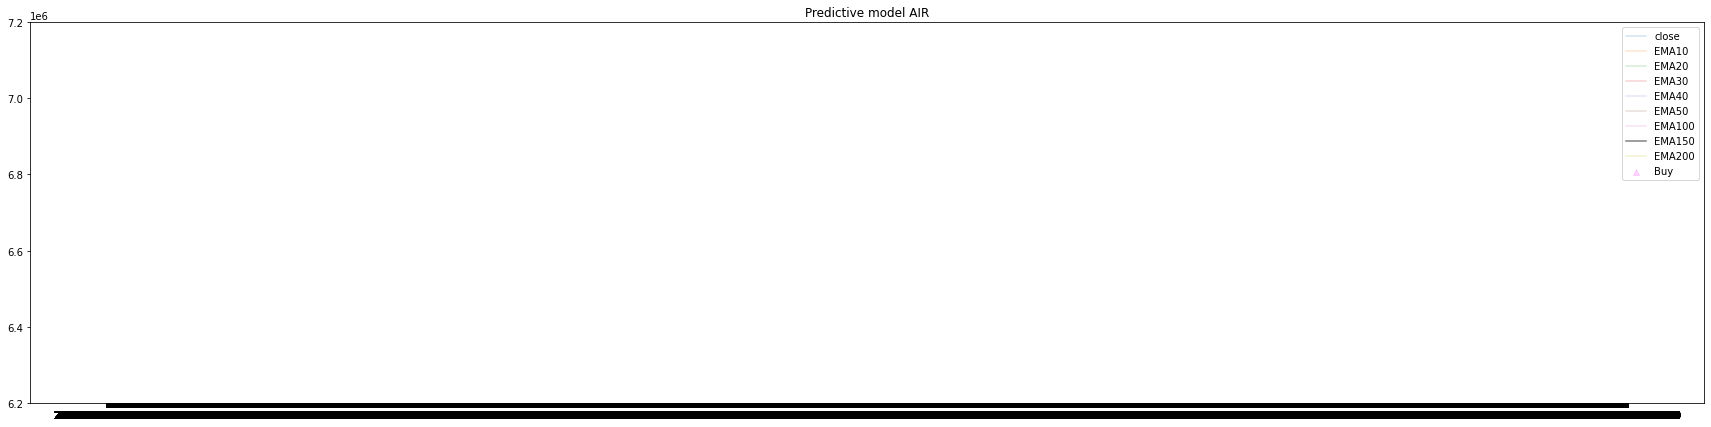

In [60]:
#plt.ylim(500000,700000)
plot_stock_prediction(new_df, ticker)
#plot_stock_prediction

In [98]:
# zoom in on the data
temp_df = new_df[9000:10000]
temp_df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,EMA5,...,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,target_cls,Buy
9000,1578376860,2020/1/7 6:01,BTC/USD,7882.00,7882.00,7876.00,7880.52,1.714254,13509.211510,7878.579140,...,0,0,0,0,0,0,0,0,1,1
9001,1578376920,2020/1/7 6:02,BTC/USD,7876.00,7877.31,7869.86,7869.86,7.217657,56801.946420,7875.672760,...,0,0,0,0,0,0,0,0,1,0
9002,1578376980,2020/1/7 6:03,BTC/USD,7875.86,7878.39,7869.87,7872.30,0.904608,7121.345322,7874.548507,...,0,0,0,0,0,0,0,0,0,0
9003,1578377040,2020/1/7 6:04,BTC/USD,7870.02,7875.94,7870.02,7870.02,0.083872,660.072429,7873.039005,...,0,0,0,0,0,0,0,0,0,0
9004,1578377100,2020/1/7 6:05,BTC/USD,7875.01,7875.01,7866.68,7866.68,1.215806,9564.358632,7870.919336,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1578436560,2020/1/7 22:36,BTC/USD,8022.44,8035.45,8013.71,8035.45,0.130527,1048.839647,8016.712594,...,0,0,0,0,0,0,0,0,0,0
9996,1578436620,2020/1/7 22:37,BTC/USD,8033.93,8038.37,8033.25,8033.25,0.717106,5760.688802,8022.225063,...,0,0,0,0,0,0,0,0,0,0
9997,1578436680,2020/1/7 22:38,BTC/USD,8033.25,8036.97,8027.22,8036.97,0.170990,1374.242947,8027.140042,...,0,0,0,0,0,0,0,0,0,0
9998,1578436740,2020/1/7 22:39,BTC/USD,8025.09,8036.36,8025.09,8026.63,0.202778,1627.620527,8026.970028,...,0,0,0,0,0,0,0,0,0,0


In [103]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(30,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['date'], df['close'], label='close', alpha=0.2)

    plt.plot(df['date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['date'], df['EMA200'], label='EMA200', alpha=0.2)


    plt.scatter(df['date'], df['Buy']*df['close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')
    plt.ylim(7700,8200)

    plt.legend()

    plt.show()

    return None   

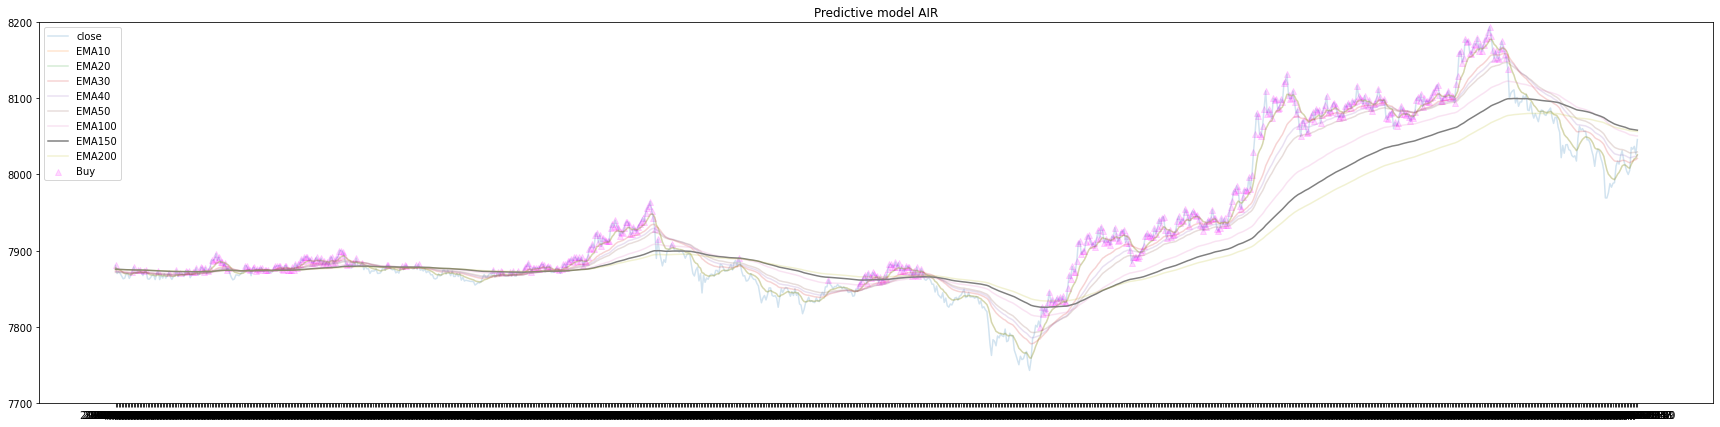

In [104]:
#plt.ylim(100000,700000)
plot_stock_prediction(temp_df,ticker)